Data Cleaning
===

We'll look at how to detect and remove bad data.

Outliers
---

Outliers are data points that fall far away from the center of a distribution of data. The terms "far away" and "center" could mean a couple of different things. We often describe the center of a distribution by its mean and measure the distance from that center in terms of units of the distribution's standard deviation. For a normal distribution 99.7% of points are within 3 standard deviations of the mean, so points that are more than 3 or 4 standard deviations from the mean might be considered "far away". However, when a data set contains extreme outliers (in either number or distance), they can have a significant effect on both the mean and standard deviation.

Let's look at an example. We'll generate a sine wave for values between 0 and 2pi and add a little bit of gaussian noise.

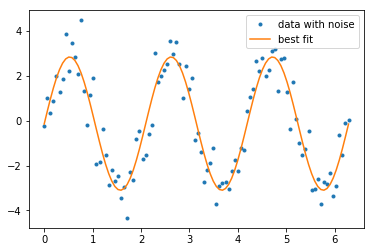

the average value is -0.13165531985610857. the standard deviation is 2.234557045639745
the r-square value is 0.8754791396996179.


In [1]:
import numpy as np
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
from math import pi

%matplotlib inline
from matplotlib import pyplot


# function to generate a custom sine wave
def custom_sin(t, A, phase, offset):
    return A * np.sin(t*3 + phase) + offset

# generate a sine wave with amplitude of 3, 0 phase, 0 offset, and a little gaussian noise
t = np.linspace(0, 2*pi, 100)
y = custom_sin(t, 3, 0, 0) + np.random.normal(0, 0.8, 100)

# generate a best fit curve for our generated noisey data
C = curve_fit(custom_sin, t, y, p0=[1, 0, 0])
y_fit = custom_sin(t, *C[0])

pyplot.plot(t, y, '.', label='data with noise')
pyplot.plot(t, y_fit, label='best fit')
pyplot.legend()
pyplot.show()

print('the average value is %s. the standard deviation is %s' % (np.mean(y), np.std(y)))
print('the r-square value is %s.' % r2_score(y, y_fit))

The sine wave we created has an amplitude of 3 and zero offset so we'd expect the standard deviation to be less than 3 and the mean value to be close to zero, which is about what we get. We also fit a curve to the generated data points and got an r-squre value of 0.88 (remember 1 is a perfect fit so that's not bad).

Now let's add a few outliers

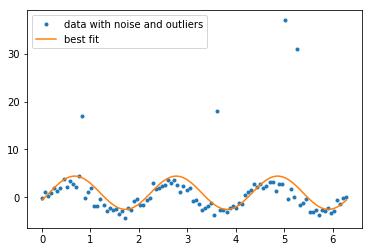

the average value is 0.9117342217647894. the standard deviation is 5.78623089126189
the r-square value is 0.18060173057912232.


In [2]:
# replacing four data points from the generated sine wave with outliers
y[13] = 17
y[57] = 18
y[79] = 37
y[83] = 31

# now try to fit a sine wave to the data with outliers
C = curve_fit(custom_sin, t, y, p0=[1, 0, 0])
y_fit = custom_sin(t, *C[0])

pyplot.plot(t, y, '.', label='data with noise and outliers')
pyplot.plot(t, y_fit, label='best fit')
pyplot.legend()
pyplot.show()

print('the average value is %s. the standard deviation is %s' % (np.mean(y), np.std(y)))
print('the r-square value is %s.' % r2_score(y, y_fit))

The four outliers have pulled the best fit curve up and to the left and had a significant effect on the mean, the standard deviation, and the r-squared value. The standard deviation has been so stretched out by the presence of the outliers that two of the outliers now fall within 3 standard deviations of the mean. Because the mean and standard deviation are so sensitive to outliers we need to find alternative robust measures of central tendency and scale.

A common, robust, alternative to the mean and standard deviation are the median and median absolute difference (MAD). You're probably already familiar with the median and I'll send you to wikipedia for the [definition of the median absolute difference](https://en.wikipedia.org/wiki/Median_absolute_deviation). The MAD is not as common as standard deviation and as a result isn't included as part of the numpy library. It's available elsewhere, but, as with r-squared, the definition is simple enough that we'll write our own function to calculate it.

In [3]:
def mad(x):
    xmed = np.median(x)  # calculate the median value
    return np.median(np.abs(x-xmed))  # take the median of the difference between all the x values and xmed

Let's plot a histogram of the y-values of our generated sine wave + outliers and calculate the median and MAD.

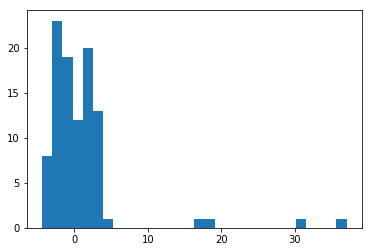

the average value is 0.9117342217647894. the standard deviation is 5.78623089126189
the median value is -0.2208704529132613. the MAD is 2.120992614305125


In [4]:
pyplot.hist(y, bins=30)
pyplot.show()
print('the average value is %s. the standard deviation is %s' % (np.mean(y), np.std(y)))
print('the median value is %s. the MAD is %s' % (np.median(y), mad(y)))

The MAD is much less affected by the presence of the outliers than the standard deviation. Now that we have a robust measure of "far away"-ness, we can use it to detect and remove outliers from our data.

**Note:** Outliers can occur as the result of erroneous data collection or rare events. Erroneous data should be removed (and, if possible, the mechanism that collected the erroneous data should be fixed), but data points from rare events shouldn't. In many cases those outliers represent a phenomenon worth studying.

Let's put our generated sine wave data into a pandas dataframe so we can slice and filter easily.

In [5]:
ymed = np.median(y)
ymad = mad(y)

import pandas as pd
sin_df = pd.DataFrame({'t': t, 'y': y})

Now let's pull out the outliers by locating all y values that are more than 5 MADs from the median

In [6]:
sin_df.loc[np.abs(sin_df['y']) > ymed + 5*ymad]

,t,y
13,0.825065,17.0
57,3.617592,18.0
79,5.013855,37.0
83,5.267721,31.0


These are indeed the four outliers that we added to our data earlier. We can also use panda's `loc` method to remove these outliers by passing the inverse condition into `loc`.

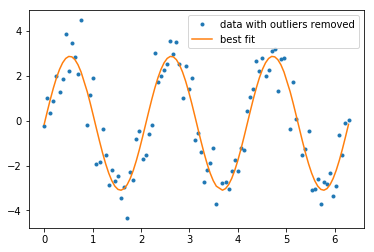

the average value is -0.12319351899501098. the standard deviation is 2.2516562516875136
the median value is -0.3666272813533451. the MAD is 2.1037504282571726
the r-square value is 0.873939894998512.


In [7]:
sin_df_cleaned = sin_df.loc[np.abs(sin_df['y']) < ymed + 4*ymad]
y = sin_df_cleaned['y'] 
t = sin_df_cleaned['t'] 

C = curve_fit(custom_sin, t, y, p0=[1, 0, 0])
y_fit = custom_sin(t, *C[0])

pyplot.plot(t, y, '.', label='data with outliers removed')
pyplot.plot(t, y_fit, label='best fit')
pyplot.legend()
pyplot.show()

print('the average value is %s. the standard deviation is %s' % (np.mean(y), np.std(y)))
print('the median value is %s. the MAD is %s' % (np.median(y), mad(y)))
print('the r-square value is %s.' % r2_score(y, y_fit))

**Note:** How many MADs from the median that qualifies something as an outlier is up to you and depends on the distribution in question and how aggressive you want to be with removing potential outliers. You could choose to remove anything greather than 3 MADs from the median, but you'll probably also throw out a few valid data points. You could make the MAD threshold larger, but if you make it too large you'll miss some outliers. 4 to 6 MADs is generally a good threshold, but you may want to make that smaller or larger depending on you data and how important removing every outlier is.

PCA
---
Let's look at a slightly trickier problem. Suppose you have the situation below.

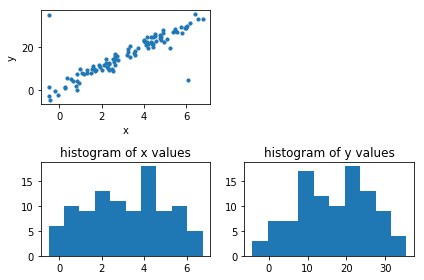

In [8]:
C0 = 1
C1 = 5

# generate a linear data with gaussian noise
x = np.linspace(0, 2*pi, 100) + np.random.normal(0, 0.5, 100)
y = C0 + C1*x + np.random.normal(0, 2, 100)

# add two outliers
y[5] = 35
y[92] = 5
pyplot.figure(1)
pyplot.subplot(221)
pyplot.scatter(x, y, s=10)
pyplot.xlabel('x')
pyplot.ylabel('y')

pyplot.subplot(223)
pyplot.hist(x)
pyplot.title('histogram of x values')

pyplot.subplot(224)
pyplot.hist(y)
pyplot.title('histogram of y values')

pyplot.tight_layout()
pyplot.show()

There are two outliers (in the uppper left and lower right corners), but if we plot the histogram along either the x or y axis those outliers don't show up. The problem is that these two points are not particularly far away from the center of the distribution, they're just far from the line that all of the other points fall near. We could determine which points are outliers if we could measure their distance from that line rather than the distance from the center of the distribution.

We'll use Principal Component Analysis (PCA) to do just that. PCA identifies the directions that our data are most spread out across (aka the principal components) and allows us to transform the data so that the spread is reduced to a lower number of dimensions. In our case we'll find the principal component for the spread across two dimensions (x and y) and transform the data so that most of the spread is only in one dimension.

In [9]:
from sklearn import decomposition
import pandas as pd

# put our data in a data frame before performing PCA
X = pd.DataFrame({'x': x, 'y': y})

pca = decomposition.PCA(n_components=2)
pca.fit(X)
Xp = pca.transform(X).T

Xp is the transformed dataset. It's an numpy array where Xp[0] is the transformation along the x-axis and Xp[1] is the transformation along the y-axis. Let's plot the transformed results.

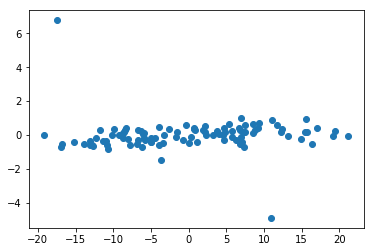

In [10]:
pyplot.scatter(Xp[0], Xp[1])
pyplot.show()

Notice that most of the variance is now in 1 dimension (along the x-axis). Our outliers are anomalous because they are far from this principal component. If we plot a histogram along the axis perpendicular to the principal axis (now the y-axis) the outliers should become very apparent.

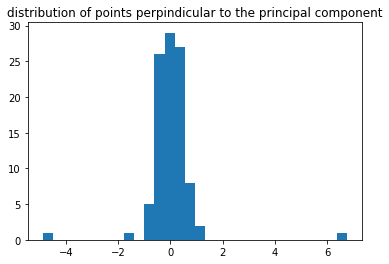

In [11]:
pyplot.hist(Xp[1], bins=30)
pyplot.title('distribution of points perpindicular to the principal component')
pyplot.show()

Let's add the transformed values along the y-axis to the dataframe we created ealier and use them to help filter out the outliers.  As with the sine wave example we'll calculate the median and MAD for the transformed y-values and assume any data point with a yp value more than 5 MADs from the median is an outlier.

In [12]:
X['yp'] = Xp[1]
pmed = np.median(X['yp'])
pmad = mad(X['yp'])
print('median value: %s  MAD value: %s' % (pmed, pmad))

X.loc[np.abs(X['yp']) > pmed + 5*pmad]

median value: 0.012186469840289205  MAD value: 0.30722714975194215


,x,y,yp
5,-0.506623,35.0,6.765891
92,6.060789,5.0,-4.888758


Our filtering condition successfully identified the outliers. Now let's use the inverse condition to remove them.

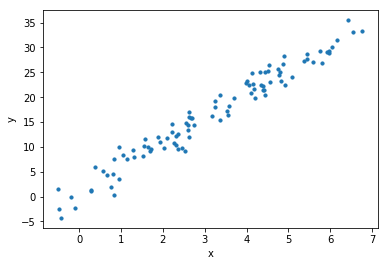

In [13]:
X_cleaned = X.loc[np.abs(X['yp']) < pmed + 4*pmad]
pyplot.scatter(X_cleaned['x'], X_cleaned['y'], s=10)
pyplot.xlabel('x')
pyplot.ylabel('y')
pyplot.show()

Two final things to note:
1. PCA works best with linear data. If you know you have data that follows an exponential curve, perform a log transform before performing PCA.
2. We used PCA with a 2-dimensional data set, but PCA works just as well with many many more dimensions.